In [1]:
import numpy as np
import pandas as pd 
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.fft import fft
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error, mean_squared_error
from datetime import datetime 

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import LassoCV

In [2]:
root = 'D:/Jupyterfiles/ThermalData/2021-01/'
file_paths = os.listdir(root)

data = pd.read_excel(os.path.join(root, file_paths[0]))
for i in range(1, len(file_paths)):
    single_file_data = pd.read_excel(os.path.join(root, file_paths[i]))
    data = pd.merge(data, single_file_data, how='left', on=['时间'])

### 数据处理

In [3]:
internal_factors = ['10MKA10CE301XQ01', '10MKA10CE301XQ02', '10MKA10CE101XQ01', '10MKA10CE101XQ02', '10MKA10CE101XQ03',
                  '10MKF30CT302', '10MKG10CT301', '10MKG10CT303', '10MKG10CT305', '10MKG10CT307']

external_factors = ['10MKA01CT301','10MKA01CT303','10MKA01CT305','10MKA01CT307','10MKA01CT309','10MKA01CT311',
                    '10MKA01CT313','10MKA01CT315','10MKA01CT317','10MKA01CT319','10MKA01CT321','10MKA01CT323',
                    '10MKA01CT325','10MKA01CT327','10MKA01CT329','10MKA01CT331','10MKA01CT333','10MKA01CT335',
                    '10MKA01CT337','10MKA01CT339','10MKA01CT341','10MKA01CT343','10MKA01CT345','10MKA01CT347',
                    '10MKA01CT349','10MKA01CT351','10MKA01CT353','10MKA01CT355','10MKA01CT357','10MKA01CT359',
                    '10MKA01CT361','10MKA01CT363','10MKA01CT365','10MKA01CT367','10MKA01CT369','10MKA01CT371','10MKA01CT373',
                    '10MKA01CT375','10MKA01CT377','10MKA01CT379','10MKA01CT381','10MKA01CT383','10MKA01CT601','10MKA01CT602',
                    '10MKA01CT603','10MKA01CT604','10MKA01CT605','10MKA01CT606','10MKA01CT607','10MKA01CT608','10MKA01CT609',
                    '10MKA01CT610','10MKA01CT611','10MKA01CT612','10MKA01CT613','10MKA01CT614','10MKA01CT615','10MKA01CT616',
                    '10MKA01CT617','10MKA01CT618']

target_column=['10MKA10CE301XQ01']

In [4]:
# 数据类型更改和校验、数据拼接
data['TIME'] = pd.to_datetime(data['TIME'])
data = data.infer_objects()
data.columns =[col.strip() for col in data.columns]
internal_factors = list(map(str.strip, internal_factors))
external_factors = list(map(str.strip, external_factors))
target_column = list(map(str.strip, target_column))
df = data[list(set(['TIME'] + internal_factors + external_factors + target_column))]

df = df.query("`10MKA10CE301XQ01` > 50")
df = df.fillna(df.mean()).reset_index(drop=True)
df 

,10MKA01CT616,10MKF30CT302,10MKA01CT614,10MKA01CT301,10MKA01CT375,10MKA01CT355,10MKA01CT610,10MKA01CT603,10MKA01CT305,TIME,...,10MKA01CT361,10MKA01CT609,10MKA01CT365,10MKA10CE301XQ02,10MKA01CT367,10MKA01CT345,10MKA01CT333,10MKA01CT618,10MKA01CT353,10MKA01CT335
0,45.571431,40.782337,43.251492,48.542645,49.343246,47.129146,46.449845,45.648443,49.850502,2021-01-01 00:00:00,...,52.641781,42.954588,49.470055,30.699219,48.962856,49.977325,48.709290,45.444761,49.723679,48.531802
1,46.491872,41.111195,43.644676,48.834506,49.470055,47.315006,46.449838,45.425684,50.104156,2021-01-01 00:30:00,...,52.768715,43.162907,49.596863,35.494482,49.089649,50.104156,48.836071,45.778702,49.850502,48.582512
2,46.556899,41.743710,43.513538,49.177155,49.723679,47.695206,46.135410,45.736603,50.433939,2021-01-01 01:00:00,...,53.149540,42.915893,49.977325,10.618408,49.470055,50.484676,49.216446,45.740217,50.230991,48.962856
3,46.303973,41.743710,43.652269,49.177155,49.723679,47.568466,46.503374,45.525391,50.357834,2021-01-01 01:30:00,...,53.022594,43.239925,49.850502,7.450049,49.381289,50.357834,49.089649,45.740217,50.230991,48.836071
4,45.632652,41.617195,42.942677,48.415760,48.962856,46.808140,45.763241,45.295003,49.470055,2021-01-01 02:00:00,...,52.134102,42.842457,49.089649,-6.679443,48.709290,49.596863,48.328972,44.975907,49.470055,48.202209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,48.908298,43.262230,46.327650,51.589413,52.134102,50.484676,47.843213,49.007668,52.895653,2021-01-31 22:00:00,...,55.689495,45.222584,52.134102,-81.993066,51.499611,52.895653,51.499611,48.610760,52.514854,50.992104
1485,49.148505,43.009094,46.580556,51.462406,52.007195,50.230991,48.038071,48.797813,52.768715,2021-01-31 22:30:00,...,55.562450,45.395409,52.007195,-83.577197,51.372726,52.641781,51.372726,48.748110,52.261017,50.865242
1486,48.698403,43.009094,46.151197,51.462406,52.007195,50.230991,48.060989,48.969429,52.768715,2021-01-31 23:00:00,...,55.562450,45.510593,52.007195,-85.332666,51.372726,52.768715,51.480578,48.366386,52.337166,50.865242
1487,48.664066,43.009094,46.128193,51.335407,51.880291,50.230991,47.759022,49.026623,52.692554,2021-01-31 23:30:00,...,55.562450,45.149487,51.880291,-94.495280,51.330434,52.641781,51.372726,48.404556,52.261017,50.738380


In [46]:
# df[['TIME']+target_column][df[['TIME']+target_column]['TIME']<"2021-01-30 10:30:00"].tail(10)

In [23]:
# df.query("TIME <= '2021-01-30 09:30:20'")[['TIME','10MKA01CT361']].tail(15)

In [5]:
# 根据时间区分训练集（"时间 < '2021-01-22 00:00:00'"）、
# 验证集（"时间 >= '2021-01-22 00:00:00' & 时间 < '2021-01-27 00:00:00'"）、
# 测试集（"时间 >= '2021-01-27 00:00:00'"）
# df_xc = df.query("时间 < '2021-01-01 07:00:00'").reset_index(drop=True)
df_train = df.query("TIME < '2021-01-28 00:00:00'").reset_index(drop=True)
df_val = df.query("TIME >= '2021-01-28 00:00:00' & TIME < '2021-01-30 00:00:00'").reset_index(drop=True)
df_test = df.query("TIME >= '2021-01-30 00:00:00'").reset_index(drop=True)

In [6]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)
print(target_column)

(1296, 71)
(96, 71)
(97, 71)
['10MKA10CE301XQ01']


### 提取特征

In [7]:
def convert_sliding_window_data(data, target_column, window_size):
    df_sliding_window = data.copy()
    new_elements = df_sliding_window.columns.tolist()
    new_elements.remove("TIME")
    
    # 每个变量都进行shift
    shift_cols = []
    shift_col_names = []
    for i in range(len(new_elements)):
        for window in window_size:
            shift_cols.append(df_sliding_window[new_elements[i]].shift(window))
            shift_col_names.append(f'{new_elements[i]}_{window}')
    
    # 按照window计算统计特征
    stats_cols = []
    stats_col_names = []
    for window in window_size[:-2]:
        f_min = lambda x: x.rolling(window=window).min()
        f_max = lambda x: x.rolling(window=window).max()
        f_mean = lambda x: x.rolling(window=window).mean()
        f_std = lambda x: x.rolling(window=window).std()
        f_median = lambda x: x.rolling(window=window).median()
#         f_skew = lambda x:x.rolling(window=window).skew()
#         function_list = [f_min, f_max, f_mean, f_std, f_median, f_skew]
#         function_name = ['min', 'max', 'mean', 'std', 'median', 'skew']
        function_list = [f_min, f_max, f_mean, f_std, f_median]
        function_name = ['min', 'max', 'mean', 'std', 'median']
        for k in range(len(function_list)):
            stats_cols.append(df_sliding_window[new_elements].apply(function_list[k]).shift(1))
            stats_col_names.extend(pd.Series(df_sliding_window[new_elements].columns)
                                   .apply(lambda x:x+str(f'_rolling_{window}_{function_name[k]}')).tolist())
            
    x_shift = pd.concat(shift_cols, axis=1)
    x_shift.columns = shift_col_names

    x_stats = pd.concat(stats_cols, axis=1)
    x_stats.columns = stats_col_names
    
    df_sliding_window = pd.concat([df_sliding_window, x_shift, x_stats], axis=1)
            
    # 提取时间性的特征
    df_sliding_window['Day'] = df_sliding_window['TIME'].dt.day
    df_sliding_window['DayOfWeek'] = df_sliding_window['TIME'].dt.dayofweek
    df_sliding_window['Hour'] = df_sliding_window['TIME'].dt.hour 
    df_sliding_window['minute'] = df_sliding_window['TIME'].dt.minute 
    
    # 缺失值剔除+原变量剔除(因变量除外)
    new_elements.remove(target_column[0])
    df_sliding_window = df_sliding_window.dropna(axis=0, how='any').drop(new_elements, axis=1)
    return df_sliding_window.reset_index(drop=True)

In [9]:
time1 = datetime.now()
# window_size=[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
# window_size = [4, 3, 2, 1]
window_size=[6, 5, 4, 3, 2, 1]
df_train_window = convert_sliding_window_data(df_train, target_column, window_size)
df_val_window = convert_sliding_window_data(df_val, target_column, window_size)
df_test_window = convert_sliding_window_data(df_test, target_column, window_size)
time2 = datetime.now()
print(time2-time1)

0:00:00.951953


In [11]:
print(df_train_window.shape)
print(df_val_window.shape)
print(df_test_window.shape)

(1290, 1826)
(90, 1826)
(91, 1826)


In [13]:
# df_train_window[ ['TIME']+ df_train_window.columns[df_train_window.columns.str.contains('10MKA01CT603')].tolist()]

In [14]:
# df_train.query("TIME <= '2021-01-01 03:00:00'")[['10MKA01CT603', 'TIME']]

#### 制作未来半个小时待预测的数据集

In [15]:
def make_window_predict_data(data, window_size):
    max_window = max(window_size)
    df_tobe_predicted = data.tail(max_window).copy()
    new_elements = df_tobe_predicted.columns.tolist()
    new_elements.remove("TIME")
    
    shift_cols = []
    shift_col_names = []
    for i in range(len(new_elements)):
        for window in window_size[1:]:
            shift_cols.append(df_tobe_predicted[new_elements[i]].shift(window))
            shift_col_names.append(f'{new_elements[i]}_{window+1}')
    
    stats_cols = []
    stats_col_names = []
    for window in window_size[:-2]:
        f_min = lambda x: x.rolling(window=window).min()
        f_max = lambda x: x.rolling(window=window).max()
        f_mean = lambda x: x.rolling(window=window).mean()
        f_std = lambda x: x.rolling(window=window).std()
        f_median = lambda x: x.rolling(window=window).median()
        function_list = [f_min, f_max, f_mean, f_std, f_median]
        function_name = ['min', 'max', 'mean', 'std', 'median']
        for k in range(len(function_list)):
            stats_cols.append(df_tobe_predicted[new_elements].apply(function_list[k]))
            stats_col_names.extend(pd.Series(df_tobe_predicted[new_elements].columns)
                                   .apply(lambda x:x+str(f'_rolling_{window}_{function_name[k]}')).tolist())  
            
    x_shift = pd.concat(shift_cols, axis=1)
    x_shift.columns = shift_col_names

    x_stats = pd.concat(stats_cols, axis=1)
    x_stats.columns = stats_col_names
    df_tobe_predicted = pd.concat([df_tobe_predicted, x_shift, x_stats], axis=1).dropna(axis=0)
    
    df_tobe_predicted['Day'] = df_tobe_predicted['TIME'].dt.day
    df_tobe_predicted['DayOfWeek'] = df_tobe_predicted['TIME'].dt.dayofweek
    df_tobe_predicted['Hour'] = df_tobe_predicted['TIME'].dt.hour 
    df_tobe_predicted['minute'] = df_tobe_predicted['TIME'].dt.minute 
    
    df_tobe_predicted.rename({new_elements[i]: new_elements[i]+str(f'_1') for i in range(len(new_elements))}, axis=1, inplace=True)
    return df_tobe_predicted

In [22]:
val_predict = make_window_predict_data(df_val, window_size)
test_predict = make_window_predict_data(df_test, window_size)
# df_th_predict = make_window_predict_data(df_th, window_size)

In [179]:
# val_predict[   ['时间'] + val_predict.columns[val_predict.columns.str.contains('10MKA10CE301XQ02')].tolist()     ]
# df_val_window[ ['时间'] +df_val_window.columns[df_val_window.columns.str.contains('10MKA10CE301XQ02')].tolist()    ].tail(1)

In [180]:
# val_predict[   ['时间'] + val_predict.columns[val_predict.columns.str.contains(target_column[0])].tolist()     ]
# df_val_window[ ['时间'] +df_val_window.columns[df_val_window.columns.str.contains(target_column[0])].tolist()    ].tail(1)

In [151]:
# max_window = max(window_size)
# df_tobe_predicted = df_val.tail(max_window).copy()[['时间',target_column[0], '10MKA10CE301XQ02']]
# new_elements = df_tobe_predicted.columns.tolist()
# new_elements.remove("时间")

# shift_cols = []
# shift_col_names = []
# for i in range(len(new_elements)):
#     for window in window_size[1:]:
#         shift_cols.append(df_tobe_predicted[new_elements[i]].shift(window))
#         shift_col_names.append(f'{new_elements[i]}_{window+1}')

# x_shift = pd.concat(shift_cols, axis=1)
# x_shift.columns = shift_col_names
# pd.concat([df_tobe_predicted, x_shift], axis=1)

###  特征选择+模型训练+滑窗预测

In [23]:
train_cols = df_train_window.columns.tolist()
train_cols.remove('TIME')
train_cols.remove(target_column[0])

In [24]:
target_column[0] in train_cols

False

In [25]:
x_train, y_train = df_train_window[train_cols], df_train_window[target_column]
x_val, y_val = df_val_window[train_cols], df_val_window[target_column]
x_test, y_test = df_test_window[train_cols], df_test_window[target_column]

In [26]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(1290, 1824)
(90, 1824)
(91, 1824)


In [27]:
# 未来半个小时的数据的维度
print(val_predict[train_cols].shape)
print(test_predict[train_cols].shape)

(1, 1824)
(1, 1824)


In [28]:
# 特征选择
# reg = LassoCV(n_jobs=-1)
reg = RandomForestRegressor(n_jobs=-1) 
reg.fit(x_train.values, y_train.values) 
feature_model = SelectFromModel(reg, prefit=True, max_features=int(x_train.shape[1]*0.8))
x_train_new = feature_model.transform(x_train)
model_selected_columns = x_train.columns[feature_model.get_support()]
print("选择的特征是：", model_selected_columns)
print("特征选择后的数据：", x_train_new.shape)

选择的特征是： Index(['10MKA10CE101XQ02_1', '10MKA10CE101XQ01_1', '10MKA10CE301XQ01_1',
       '10MKA01CT379_1', '10MKA10CE301XQ02_6', '10MKA10CE301XQ02_1',
       '10MKA01CT361_1', '10MKG10CT301_6', '10MKA10CE101XQ03_1',
       '10MKA01CT603_rolling_6_std', '10MKA01CT601_rolling_5_std',
       '10MKG10CT307_rolling_4_std', '10MKG10CT303_rolling_4_std',
       '10MKF30CT302_rolling_3_mean', '10MKA01CT608_rolling_3_std',
       '10MKA10CE301XQ01_rolling_3_std', '10MKG10CT301_rolling_3_std', 'Hour'],
      dtype='object')
特征选择后的数据： (1290, 18)


In [29]:
# 随机森林
pipe = Pipeline(steps=[
('imputer', SimpleImputer(strategy='constant', fill_value=-999)),
('model', RandomForestRegressor())])
param_grid = {'model__n_estimators':[*range(10, 50, 10)],
              'model__max_depth':[*range(5, 50, 10)]}

# 网格搜索
grid = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=3, n_jobs=-1) 
grid.fit(x_train_new, y_train.values)
# grid.fit(x_train.values, y_train.values)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(fill_value=-999,
                                                      strategy='constant')),
                                       ('model', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'model__max_depth': [5, 15, 25, 35, 45],
                         'model__n_estimators': [10, 20, 30, 40]})

In [30]:
# 在验证集上的结果(mape,r2,mae,mse)、真实值和预测值的最大差异
pred_val_value = grid.predict(x_val[model_selected_columns].values)
# pred_val_value = grid.predict(x_val.values)
val_mape = mean_absolute_percentage_error(y_val.values, pred_val_value)
val_r2 = r2_score(y_val.values, pred_val_value)
val_mae = mean_absolute_error(y_val.values, pred_val_value)
val_mse = mean_squared_error(y_val.values, pred_val_value)
val_max_diff_value = max(abs(y_val.values.ravel() - pred_val_value))


# 在测试集上的结果(mape,r2,mae,mse)、真实值和预测值的最大差异
pred_test_value = grid.predict(x_test[model_selected_columns].values)
test_mape = mean_absolute_percentage_error(y_test.values, pred_test_value)
test_r2 = r2_score(y_test.values, pred_test_value)
test_mae = mean_absolute_error(y_test.values, pred_test_value)
test_mse = mean_squared_error(y_test.values, pred_test_value)
test_max_diff_value = max(abs(y_test.values.ravel() - pred_test_value))


# 未来半个小时的数据预测
val_pred_value = grid.predict(val_predict[model_selected_columns].values)[0]
test_pred_value = grid.predict(test_predict[model_selected_columns].values)[0]

In [31]:
res_featured = pd.DataFrame({ '因变量':target_column[0], 
                             'val_mape':val_mape, 'val_r2':val_r2, 'val_mae':val_mae, 'val_mse':val_mse, 
                             'val_max_diff_value':val_max_diff_value,
                             'val_pred_value':val_pred_value,
                            'test_mape':test_mape, 'test_r2':test_r2, 'test_mae':test_mae, 'test_mse':test_mse,
                            'test_max_diff_value':test_max_diff_value,
                            'test_pred_value':test_pred_value}, index=[1])

res_featured

,因变量,val_mape,val_r2,val_mae,val_mse,val_max_diff_value,val_pred_value,test_mape,test_r2,test_mae,test_mse,test_max_diff_value,test_pred_value
1,10MKA10CE301XQ01,0.069791,0.837696,38.237613,3201.948658,197.318736,425.992129,0.069553,0.818127,38.985814,3843.86984,213.010585,401.806328


In [52]:
# grid.predict(df_th_predict[model_selected_columns].values)[0]

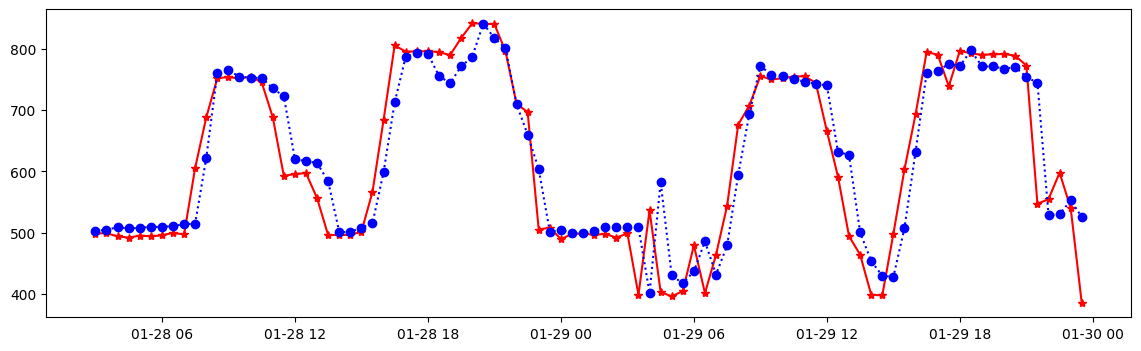

In [32]:
# 验证集真实数据和预测数据可视化
plt.figure(figsize=(14, 4))
plt.plot(df_val_window['TIME'], df_val_window[target_column], c='red', marker='*', linestyle='-', label=df_val_window[target_column])
plt.plot(df_val_window['TIME'], pred_val_value, c='blue', marker='o', linestyle=':', label='pred')

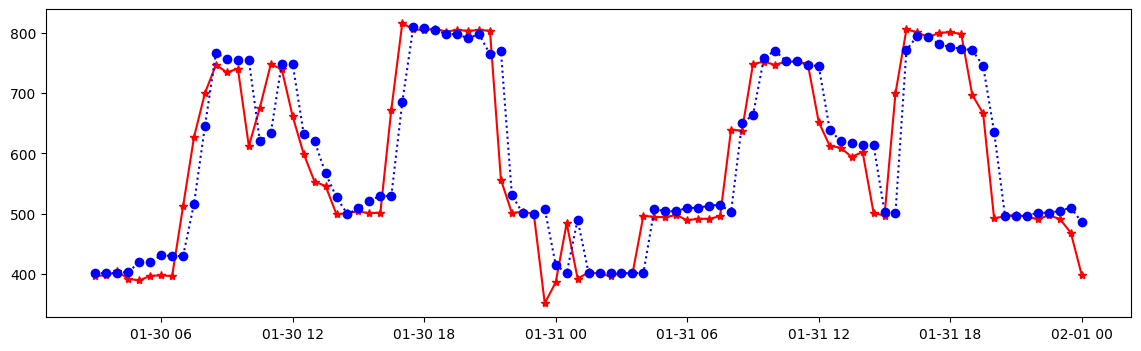

In [33]:
# 测试集真实数据和预测数据可视化
plt.figure(figsize=(14, 4))
plt.plot(df_test_window['TIME'], df_test_window[target_column], c='red', marker='*', linestyle='-', label=df_test_window[target_column])
plt.plot(df_test_window['TIME'], pred_test_value, c='blue', marker='o', linestyle=':', label='pred')